# Neural network for classification of contaminants with MAT

## 1. Formulate/outline the problem: classification

Simple neural network for classification of the contaminants using MAT transcriptomes


In [1]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import wandb
import tensorflow as tf
from tensorflow import keras

2023-11-06 15:54:58.454693: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-06 15:54:58.494452: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 15:54:58.494479: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 15:54:58.494508: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 15:54:58.502307: I tensorflow/core/platform/cpu_feature_g

In [3]:
file_name = "gene_counts_NN_training.csv"

In [4]:
data = pd.read_csv(file_name)

## 2. Identify inputs and outputs

In [5]:
data["sample"].value_counts()

sample
R848       5
CRX-527    5
CL-307     5
Pam3       5
LPS        5
PGN        5
IMDM       5
Fla-PA     3
LTA        3
Name: count, dtype: int64

## 3. Prepare data

In [6]:
data_features = data.drop(columns=["sample"])
target = data["sample"]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_features, target, test_size=0.2, random_state=0, shuffle=True, stratify=target
)

In [8]:
y_train.value_counts(), y_test.value_counts()

(sample
 Pam3       4
 R848       4
 IMDM       4
 PGN        4
 LPS        4
 CRX-527    4
 CL-307     4
 Fla-PA     2
 LTA        2
 Name: count, dtype: int64,
 sample
 Pam3       1
 R848       1
 Fla-PA     1
 CRX-527    1
 LPS        1
 LTA        1
 IMDM       1
 PGN        1
 CL-307     1
 Name: count, dtype: int64)

In [9]:
def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


X_train = to_normalize_DESeq2_style(X_train)

X_test = to_normalize_DESeq2_style(X_test)

/tmp/ipykernel_3264398/2095961712.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: max(x, 0))
/tmp/ipykernel_3264398/2095961712.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: max(x, 0))


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
encoded_labels = le.transform(y_train)
le_name_mapping = dict(zip(le.classes_, encoded_labels))

In [11]:
le_name_mapping

{'CL-307': 7,
 'CRX-527': 8,
 'Fla-PA': 3,
 'IMDM': 6,
 'LPS': 7,
 'LTA': 4,
 'PGN': 1,
 'Pam3': 3,
 'R848': 4}

In [12]:
from sklearn.feature_selection import chi2, SelectKBest

# Define feature selection
fs = SelectKBest(score_func=chi2, k=500)

# Apply feature selection
X_train = fs.fit_transform(X_train, encoded_labels)

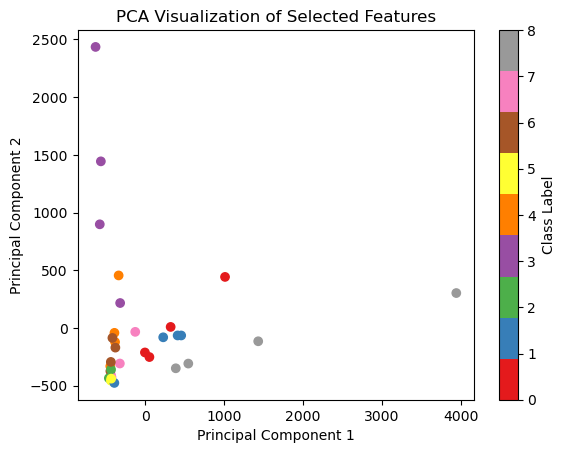

In [13]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

# Scatter plot
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=encoded_labels, cmap="Set1")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Selected Features")
plt.colorbar(label="Class Label")
plt.show()

In [14]:
# Transform the test feature matrix
X_test = fs.transform(X_test)

In [15]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

## 4. Build an architecture from scratch or choose a pretrained model

In [16]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [17]:
WANDB_NOTEBOOK_NAME = "20230829 NN first sweep"

In [18]:
sweep_config = {
    "method": "bayes",
    "name": "third_sweep",
    "metric": {
        "name": "Validation AUC",
        "goal": "maximize",
    },
    "parameters": {
        "l1": {"values": [16, 24, 32, 40]},
        "l2": {"values": [16, 24, 32, 40]},
        "epochs": {"values": [200, 280, 320]},
        "learning_rate": {"distribution": "uniform", "min": 0.008, "max": 0.02},
        "batch_size": {"values": [12]},
        "weights_limit": {"distribution": "uniform", "min": 0.008, "max": 0.02},
        "dropout_rates": {"values": [0.2, 0.3, 0.4]},
    },
}

In [19]:
sweep_id = wandb.sweep(sweep=sweep_config, project="NN-MATseq")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: lbxz4auk
Sweep URL: https://wandb.ai/afanasyeva-team/NN-MATseq/sweeps/lbxz4auk


In [20]:
default_config = {
    "l1": 32,
    "l2": 32,
    "dropout_rates": 0.3,
    "batch_size": 12,
    "activation": "relu",
    "weights_limit": 0.0114,
    "epochs": 280,
    "learning_rate": 0.0156,
    "loss": "categorical_crossentropy",
    "optimizer": "adam",
}

In [21]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=0, mode="min", restore_best_weights=True
)

In [24]:
from wandb.keras import WandbCallback


def train():
    with wandb.init(project="NN-MATseq", config=default_config) as run:
        dropout_rates = run.config.dropout_rates
        batch_size = run.config.batch_size
        activation = run.config.activation
        weights_limit = run.config.weights_limit
        epochs = run.config.epochs
        learning_rate = run.config.learning_rate
        loss = run.config.loss
        l1 = run.config.l1
        l2 = run.config.l2

        if run.config.optimizer == "adam":
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif run.config.optimizer == "sgd":
            optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
        elif run.config.optimizer == "rmsprop":
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

        inputs = keras.Input(shape=X_train.shape[1])
        x = keras.layers.UnitNormalization()(inputs)

        x = keras.layers.Dense(
            l1,
            activation=activation,
            kernel_regularizer=keras.regularizers.L2(weights_limit),
        )(x)
        x = keras.layers.Dropout(dropout_rates)(x)

        x = keras.layers.Dense(
            l2,
            activation=activation,
            kernel_regularizer=keras.regularizers.L2(weights_limit),
        )(x)
        x = keras.layers.Dropout(dropout_rates)(x)

        outputs = keras.layers.Dense(9, activation="softmax")(x)

        model = keras.Model(
            inputs=inputs, outputs=outputs, name="NN_multiclass_classifier_MATseq"
        )

        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[
                "accuracy",
                keras.metrics.AUC(name="auc"),
            ],
        )

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            verbose=True,
        )

        model.save("NN_multiclass_classifier_MATseq.keras", overwrite=True)

        wandb.log({"AUC": history.history["auc"][-1]})
        wandb.log({"Validation AUC": history.history["val_auc"][-1]})
        wandb.log({"Loss": history.history["loss"][-1]})
        wandb.log({"Validation Loss": history.history["val_loss"][-1]})
        wandb.log({"Accuracy": history.history["accuracy"][-1]})
        wandb.log({"Validation Accuracy": history.history["val_accuracy"][-1]})

In [25]:
count = 50
wandb.agent(sweep_id, train, count=count)

wandb: Agent Starting Run: co5w5ve0 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 40
wandb: 	learning_rate: 0.013624456548494677
wandb: 	weights_limit: 0.01618242959789675
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 113ms/step - loss: 3.6903 - accuracy: 0.1562 - auc: 0.5303 - val_loss: 3.0172 - val_accuracy: 0.1111 - val_auc: 0.5849
Epoch 2/320
3/3 [==============================] - 0s 26ms/step - loss: 2.8624 - accuracy: 0.1250 - auc: 0.5801 - val_loss: 2.5451 - val_accuracy: 0.2222 - val_auc: 0.6489
Epoch 3/320
3/3 [==============================] - 0s 25ms/step - loss: 2.4848 - accuracy: 0.2500 - auc: 0.6808 - val_loss: 2.3830 - val_accuracy: 0.3333 - val_auc: 0.7608
Epoch 4/320
3/3 [==============================] - 0s 26ms/step - loss: 2.3319 - accuracy: 0.3438 - auc: 0.7449 - val_loss: 2.3138 - val_accuracy: 0.2222 - val_auc: 0.7176
Epoch 5/320
3/3 [==============================] - 0s 25ms/step - loss: 2.2494 - accuracy: 0.2812 - auc: 0.7621 - val_loss: 2.2480 - val_accuracy: 0.3333 - val_auc: 0.7276
Epoch 6/320
3/3 [==============================] - 0s 24ms/step - loss: 2.1428 - accuracy: 0.3438 - auc: 0.7899 - val_loss: 2.1454 - val_ac

wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f806b097820>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f806b2e4250, execution_count=25 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f845a603550, raw_cell="count = 50
wandb.agent(sweep_id, train, count=coun.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B172.25.84.250/home/t.afanasyeva/MATseq/notebooks/20230831%20nn%20third%20sweep.ipynb#X40sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:
3/3 [==============================] - 0s 26ms/step - loss: 1.3144 - accuracy: 0.7500 - auc: 0.9675 - val_loss: 1.3683 - val_accuracy: 0.6667 - val_auc: 0.9753
Epoch 37/320
3/3 [==============================] - 0s 28ms/step - loss: 1.1487 - accuracy: 0.9062 - auc: 0.9917 - val_loss: 1.3706 - val_accuracy: 0.7778 - val_auc: 0.9707
Epoch 38/320
3/3 [==============================] - 0s 26m

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

3/3 [==============================] - 0s 31ms/step - loss: 1.1797 - accuracy: 0.9062 - auc: 0.9949 - val_loss: 1.3459 - val_accuracy: 0.6667 - val_auc: 0.9769
Epoch 44/320
3/3 [==============================] - 0s 24ms/step - loss: 1.2631 - accuracy: 0.8125 - auc: 0.9792 - val_loss: 1.4090 - val_accuracy: 0.6667 - val_auc: 0.9660
Epoch 45/320
3/3 [==============================] - 0s 26ms/step - loss: 1.2083 - accuracy: 0.7500 - auc: 0.9831 - val_loss: 1.3363 - val_accuracy: 0.6667 - val_auc: 0.9722
Epoch 46/320
3/3 [==============================] - 0s 26ms/step - loss: 1.3142 - accuracy: 0.7812 - auc: 0.9701 - val_loss: 1.4273 - val_accuracy: 0.6667 - val_auc: 0.9552
Epoch 47/320
3/3 [==============================] - 0s 24ms/step - loss: 1.0674 - accuracy: 0.8750 - auc: 0.9907 - val_loss: 1.3664 - val_accuracy: 0.6667 - val_auc: 0.9799
Epoch 48/320
3/3 [==============================] - 0s 24ms/step - loss: 1.2507 - accuracy: 0.8438 - auc: 0.9835 - val_loss: 1.2803 - val_accuracy: 

Traceback (most recent call last):
